# Exploratory Data Analysis
As a data scientist you are asked to analyze data regarding orders, people and returns with the goal of writing a report with anomalies found and insights.

## Ingest

In [1]:
import pandas as pd
import numpy as np

In [2]:
xls = pd.ExcelFile("./data/sample.xls")
df_orders = pd.read_excel(xls, 'Orders')
df_returns = pd.read_excel(xls, 'Returns')
df_people = pd.read_excel(xls, 'People')

## Analysis

Let's take a look at the returns dataframe, it has only two columns, order id is the primary key and all orders seems to be returned.It is possible that the order ids that are not in this table are the ones not returned.

### Returns analysis

In [3]:
df_returns.head()

,Returned,Order ID
0,Yes,CA-2017-153822
1,Yes,CA-2017-129707
2,Yes,CA-2014-152345
3,Yes,CA-2015-156440
4,Yes,US-2017-155999


It doesn't contain any duplicated order.

In [4]:
df_returns["Order ID"].nunique(), df_returns.shape

(296, (296, 2))

In [5]:
df_returns['Returned'].value_counts()

Yes    296
Name: Returned, dtype: int64

### People analysis

Let's take a look at the people dataframe, it has only two columns with 4 people each from a difference region. It doesn't have any kind of key or time range if we add another person to the same region, which can be alerting.

In [6]:
df_people

,Person,Region
0,Anna Andreadi,West
1,Chuck Magee,East
2,Kelly Williams,Central
3,Cassandra Brandow,South


### Join analysis

All regions in order table have correspondent person.

In [7]:
df_orders.merge(df_people, how="left", on=["Region"])["Person"].isnull().sum()

0

All returned orders are present in the orders table.

In [8]:
df_returns.merge(df_orders, how="left", on=["Order ID"])["Row ID"].isnull().sum()

0

In [9]:
df_full = df_orders.merge(df_returns, how="left", on="Order ID").merge(df_people, on="Region", how="left")
df_full["Returned"] = np.where(df_full["Returned"].isnull(), 0, 1)

### Order analysis

Let's take a look at the orders dataframe, we have all the details regarding an order. The first information is that this table is at a order/product granularity.

In [10]:
df_full.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Returned,Person
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136,0,Cassandra Brandow
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820,0,Cassandra Brandow
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714,0,Anna Andreadi
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310,0,Cassandra Brandow
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164,0,Cassandra Brandow


### Sanity check

The range of orders dates from 2014 to 2017, we have 3 years of data. Here, freshness is a very important metric to monitor.

In [11]:
df_full["Order Date"].min(), df_full["Order Date"].max()

(Timestamp('2014-01-03 00:00:00'), Timestamp('2017-12-30 00:00:00'))

The same subcategory can't belong to more than one category.

In [12]:
(df_full.groupby("Sub-Category")["Category"].nunique() > 1).sum()

0

Shipping date can't be before the order date. We indeed don't have this data issue.

In [13]:
df_full[df_full["Order Date"] > df_full["Ship Date"]]

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Returned,Person


Profit can't be greater than sales. We indeed don't have this data issue.

In [33]:
df_full[df_full["Sales"] < df_full["Profit"]]

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Returned,Person


Below we can see that there are products very unprofitable. Furthermore, there are some outliers in the data, as of max and min sales and profit.

In [14]:
df_orders.iloc[:,-4:].describe()

,Sales,Quantity,Discount,Profit
count,9994.000000,9994.000000,9994.000000,9994.000000
mean,229.858001,3.789574,0.156203,28.656896
std,623.245101,2.225110,0.206452,234.260108
min,0.444000,1.000000,0.000000,-6599.978000
25%,17.280000,2.000000,0.000000,1.728750
50%,54.490000,3.000000,0.200000,8.666500
75%,209.940000,5.000000,0.200000,29.364000
max,22638.480000,14.000000,0.800000,8399.976000


Overall all metrics seems healthy even with the unprofitable purchases.

In [15]:
df_orders.iloc[:,-4:].sum()

Sales       2.297201e+06
Quantity    3.787300e+04
Discount    1.561090e+03
Profit      2.863970e+05
dtype: float64

Let's check the metrics patterns overtime

In [16]:
df_by_order_date = df_full.groupby("Order Date").agg({"Profit": sum, "Quantity": sum, "Sales": sum})

In [17]:
def plot_monthly_time_series(data, y, x):
    plt.figure(figsize=(20,5))
    sns.lineplot(data=data.resample('M').sum(), y=y, x=x).set(title=f"{y} overtime")
    plt.show()

Sales and quantity of product sold seems to be increasing over year but profit is not following the trend. Also, we can see a seasonal pattern in sales and quantity that profit don't follow as well. Therefore, we will focus the analysis in the profit metric.

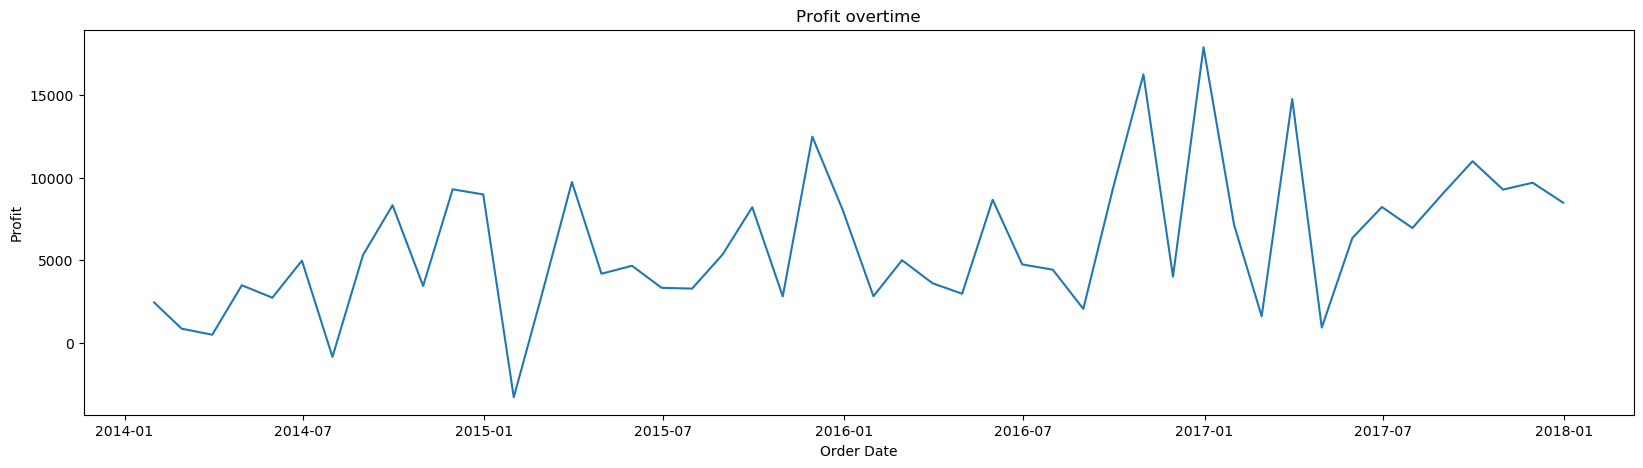

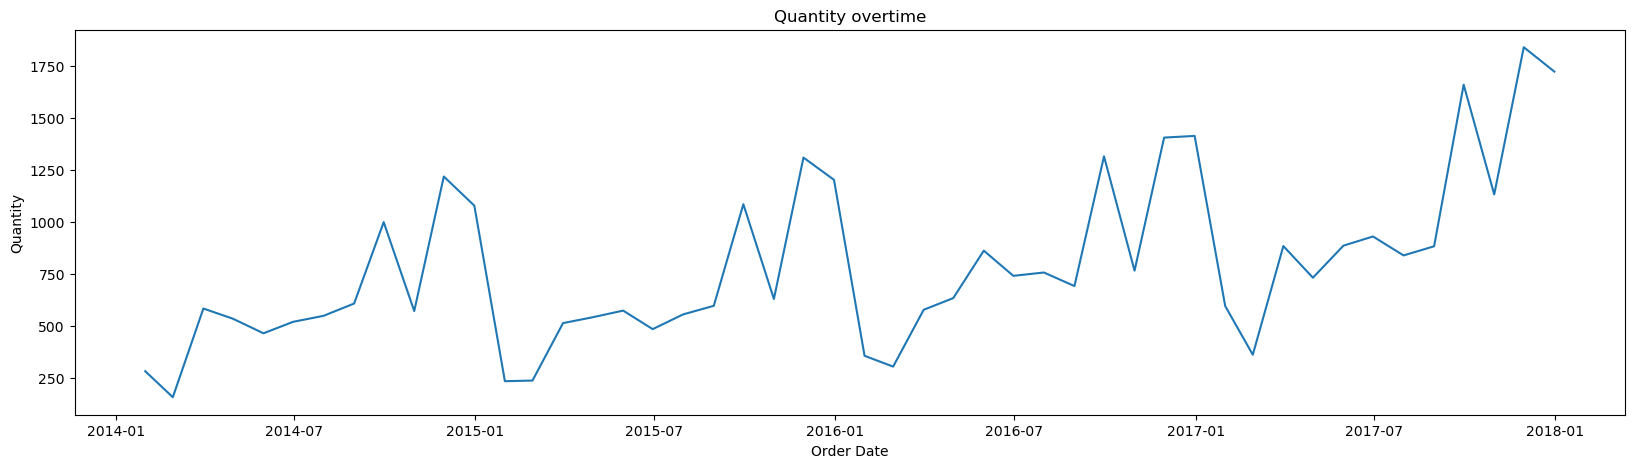

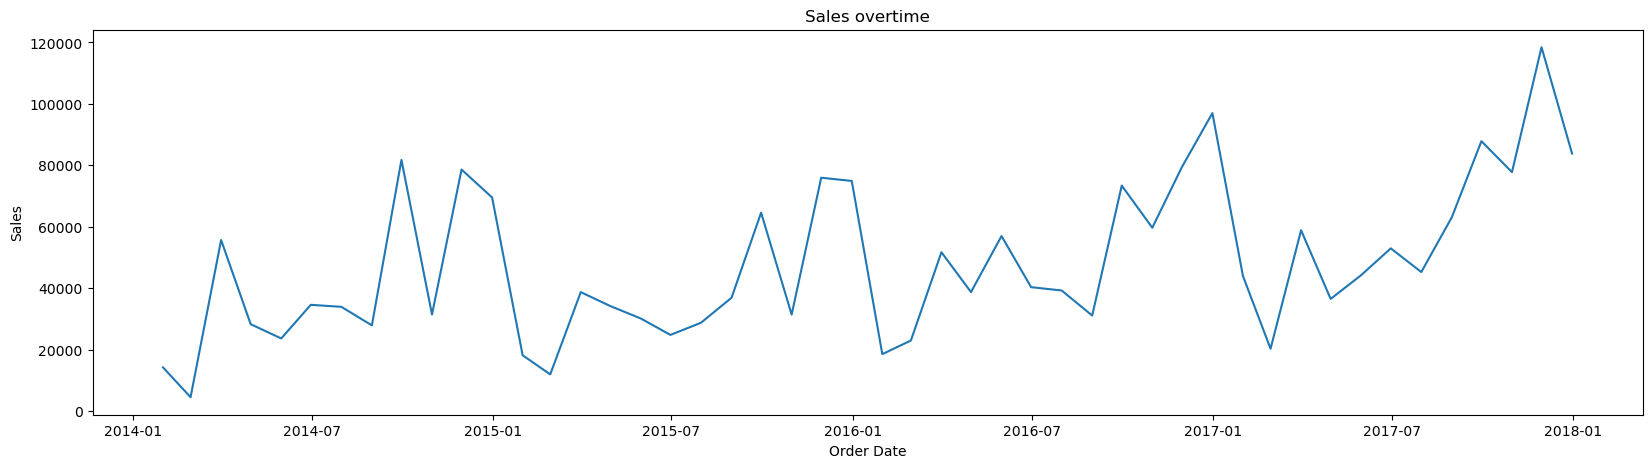

In [18]:
for var in df_by_order_date.columns.to_list():
    plot_monthly_time_series(data=df_by_order_date, y=var, x="Order Date")

The most unprofitable purchase was regarding 5 printers in 2016 bought in Lancaster. If I'm correct, the discount seems to be in percentage and there was a 70% discount in the item which may explain the negative margin. Other unprofitable itens and analysing the most profitable, which didn't have discount, seems to backup this hyphotesis.

In [19]:
df_full.sort_values(by="Profit").head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Returned,Person
7772,7773,CA-2016-108196,2016-11-25,2016-12-02,Standard Class,CS-12505,Cindy Stewart,Consumer,United States,Lancaster,...,TEC-MA-10000418,Technology,Machines,Cubify CubeX 3D Printer Double Head Print,4499.985,5,0.7,-6599.9780,0,Chuck Magee
683,684,US-2017-168116,2017-11-04,2017-11-04,Same Day,GT-14635,Grant Thornton,Corporate,United States,Burlington,...,TEC-MA-10004125,Technology,Machines,Cubify CubeX 3D Printer Triple Head Print,7999.980,4,0.5,-3839.9904,0,Cassandra Brandow
9774,9775,CA-2014-169019,2014-07-26,2014-07-30,Standard Class,LF-17185,Luke Foster,Consumer,United States,San Antonio,...,OFF-BI-10004995,Office Supplies,Binders,GBC DocuBind P400 Electric Binding System,2177.584,8,0.8,-3701.8928,1,Kelly Williams
3011,3012,CA-2017-134845,2017-04-17,2017-04-23,Standard Class,SR-20425,Sharelle Roach,Home Office,United States,Louisville,...,TEC-MA-10000822,Technology,Machines,Lexmark MX611dhe Monochrome Laser Printer,2549.985,5,0.7,-3399.9800,0,Anna Andreadi
4991,4992,US-2017-122714,2017-12-07,2017-12-13,Standard Class,HG-14965,Henry Goldwyn,Corporate,United States,Chicago,...,OFF-BI-10001120,Office Supplies,Binders,Ibico EPK-21 Electric Binding System,1889.990,5,0.8,-2929.4845,0,Kelly Williams


In [20]:
df_full.sort_values(by="Profit").tail()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Returned,Person
4098,4099,CA-2014-116904,2014-09-23,2014-09-28,Standard Class,SC-20095,Sanjit Chand,Consumer,United States,Minneapolis,...,OFF-BI-10001120,Office Supplies,Binders,Ibico EPK-21 Electric Binding System,9449.95,5,0.0,4630.4755,0,Kelly Williams
9039,9040,CA-2016-117121,2016-12-17,2016-12-21,Standard Class,AB-10105,Adrian Barton,Consumer,United States,Detroit,...,OFF-BI-10000545,Office Supplies,Binders,GBC Ibimaster 500 Manual ProClick Binding System,9892.74,13,0.0,4946.3700,0,Kelly Williams
4190,4191,CA-2017-166709,2017-11-17,2017-11-22,Standard Class,HL-15040,Hunter Lopez,Consumer,United States,Newark,...,TEC-CO-10004722,Technology,Copiers,Canon imageCLASS 2200 Advanced Copier,10499.97,3,0.0,5039.9856,0,Chuck Magee
8153,8154,CA-2017-140151,2017-03-23,2017-03-25,First Class,RB-19360,Raymond Buch,Consumer,United States,Seattle,...,TEC-CO-10004722,Technology,Copiers,Canon imageCLASS 2200 Advanced Copier,13999.96,4,0.0,6719.9808,1,Anna Andreadi
6826,6827,CA-2016-118689,2016-10-02,2016-10-09,Standard Class,TC-20980,Tamara Chand,Corporate,United States,Lafayette,...,TEC-CO-10004722,Technology,Copiers,Canon imageCLASS 2200 Advanced Copier,17499.95,5,0.0,8399.9760,0,Kelly Williams


It could be possible that another item in the same order balanced for the negative profit from the printer, but it seems that the purchase overall was also unprofitable.

In [21]:
df_full.groupby("Order ID")["Profit"].sum().sort_values()

Order ID
CA-2016-108196   -6892.3748
US-2017-168116   -3825.3394
CA-2014-169019   -3791.1634
CA-2017-134845   -3424.3546
US-2017-122714   -2929.4845
                    ...    
CA-2014-116904    4668.6935
CA-2016-117121    4946.3700
CA-2017-166709    5039.9856
CA-2017-140151    6734.4720
CA-2016-118689    8762.3891
Name: Profit, Length: 5009, dtype: float64

Almost 20,5% of the orders were unprofitable.

In [22]:
round((df_full.groupby("Order ID")["Profit"].sum() < 0).sum() / df_full["Order ID"].nunique() * 100,2)

20.4

This could be because of some loyalty program and other past purchases from the customer could be impacting. We can see below that this is not the case, we have some customers very unprofitable.

In [23]:
df_full.groupby("Customer ID")["Profit"].sum().sort_values()

Customer ID
CS-12505   -6626.3895
GT-14635   -4108.6589
LF-17185   -3583.9770
SR-20425   -3333.9144
HG-14965   -2797.9635
              ...    
AB-10105    5444.8055
HL-15040    5622.4292
SC-20095    5757.4119
RB-19360    6976.0959
TC-20980    8981.3239
Name: Profit, Length: 793, dtype: float64

In [24]:
def get_perc_profitability(data, hue):
    return round(
        (data.groupby(["Order ID", hue])["Profit"].sum() > 0).groupby(hue).sum() /
        data.groupby(["Order ID",hue])["Row ID"].count().groupby(hue).count() * 100, 2
    ).sort_values()

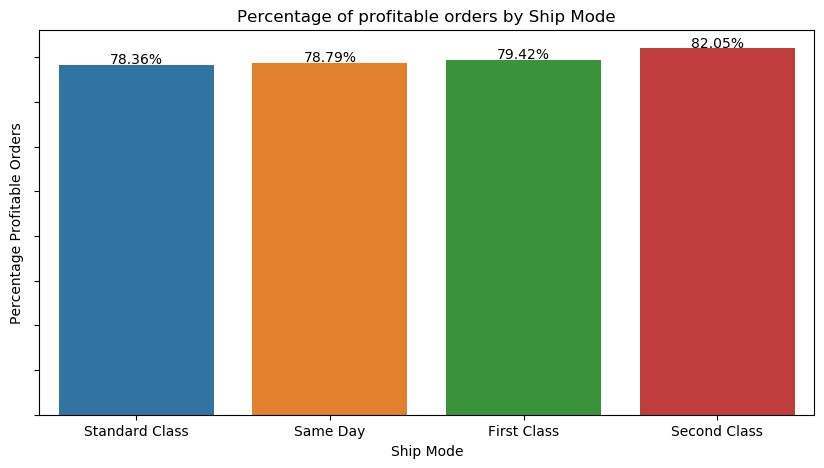

In [25]:
plot_hued_perc_profitable(df_full, "Ship Mode")

We had 5009 orders from 793 different customers

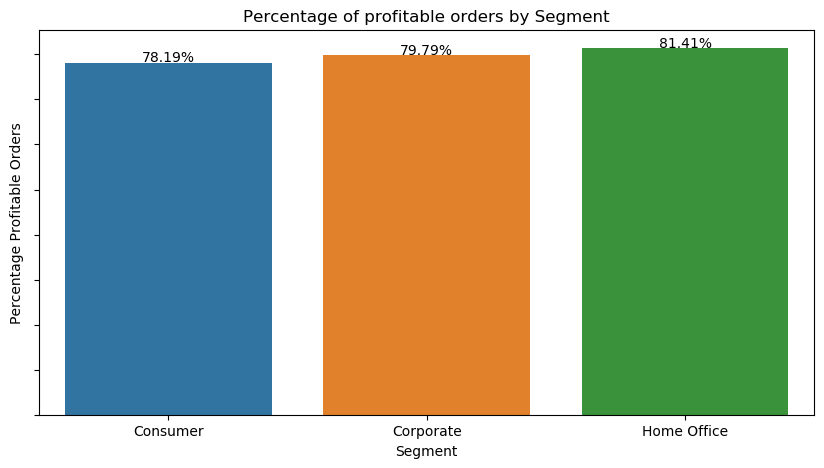

In [26]:
plot_hued_perc_profitable(df_full, "Segment")

Central region seems to be the negativily impacting profit

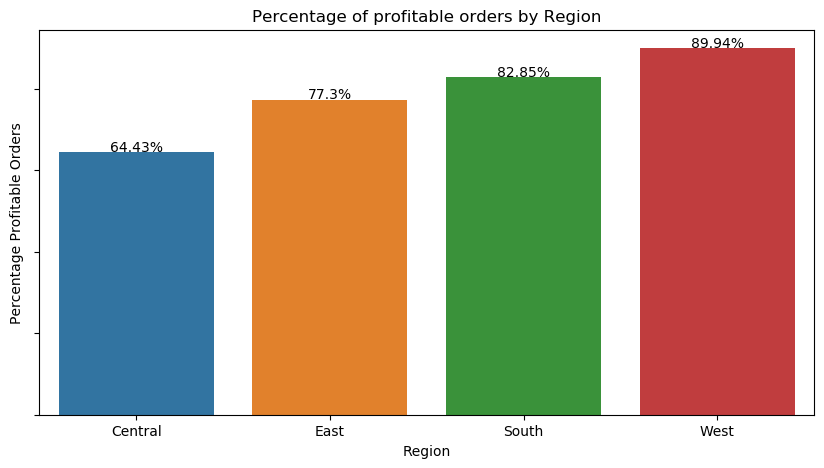

In [27]:
plot_hued_perc_profitable(df_full, "Region")

We have cities that have never made a profitable order yet.

In [28]:
get_perc_profitability(df_full, "City")

City
Elmhurst              0.0
Tamarac               0.0
Champaign             0.0
Hendersonville        0.0
Sanford               0.0
                    ...  
Dearborn            100.0
Melbourne           100.0
Dearborn Heights    100.0
Midland             100.0
Aberdeen            100.0
Length: 531, dtype: float64

In [29]:
df_full[df_full["City"]=="Elmhurst"]

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Returned,Person
2421,2422,CA-2016-155551,2016-04-18,2016-04-23,Standard Class,CR-12580,Clay Rozendal,Home Office,United States,Elmhurst,...,OFF-ST-10003656,Office Supplies,Storage,Safco Industrial Wire Shelving,230.376,3,0.2,-48.9549,0,Kelly Williams
2422,2423,CA-2016-155551,2016-04-18,2016-04-23,Standard Class,CR-12580,Clay Rozendal,Home Office,United States,Elmhurst,...,OFF-PA-10001560,Office Supplies,Paper,"Adams Telephone Message Books, 5 1/4” x 11”",9.664,2,0.2,3.2616,0,Kelly Williams
6547,6548,CA-2014-113880,2014-03-01,2014-03-05,Standard Class,VF-21715,Vicky Freymann,Home Office,United States,Elmhurst,...,FUR-CH-10000863,Furniture,Chairs,Novimex Swivel Fabric Task Chair,634.116,6,0.3,-172.1172,0,Kelly Williams
6548,6549,CA-2014-113880,2014-03-01,2014-03-05,Standard Class,VF-21715,Vicky Freymann,Home Office,United States,Elmhurst,...,OFF-PA-10003036,Office Supplies,Paper,"Black Print Carbonless 8 1/2"" x 8 1/4"" Rapid M...",17.472,3,0.2,5.6784,0,Kelly Williams


Furniture seems to be the category with less profitable orders, in which table have only 36% of profitable orders.

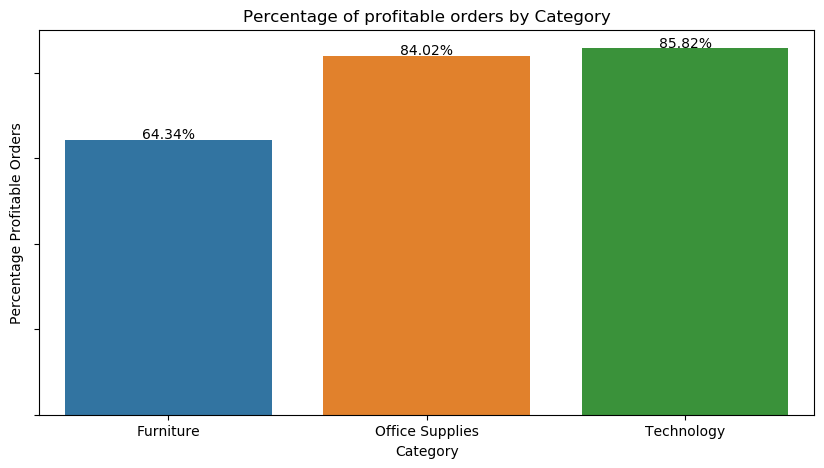

In [30]:
plot_hued_perc_profitable(df_full, "Category")

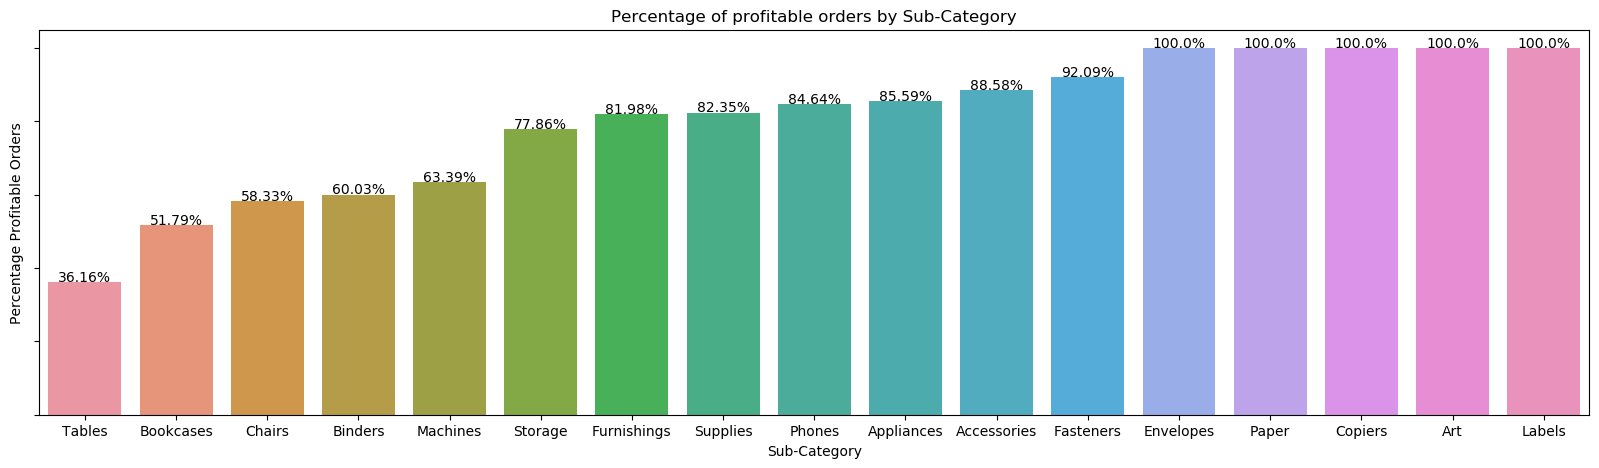

In [31]:
plot_hued_perc_profitable(df_full, "Sub-Category")

Checking if an order returned could impact the profitability, but it seems that both returned and not returne have almost the same percentage of profitable orders.

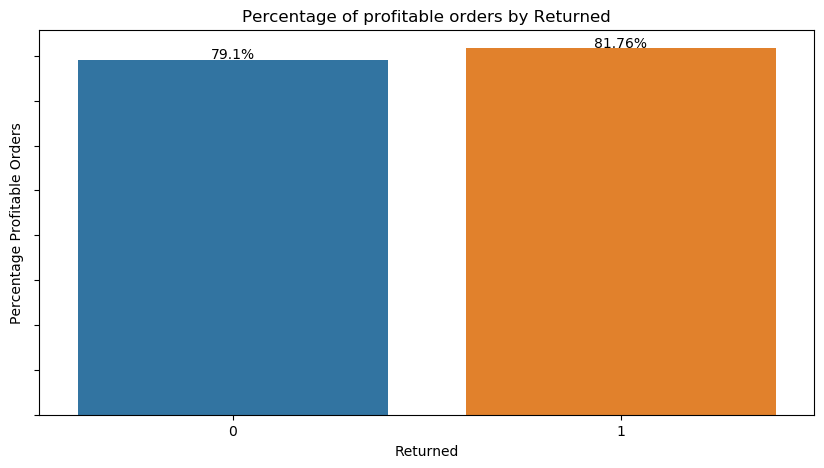

In [32]:
plot_hued_perc_profitable(df_full, "Returned")